In [1]:
%matplotlib inline

import os
from time import time 
from astropy.table import Table
from astropy.io import fits

In [2]:
bcg_basename = "s16a_massive_z0.3_0.5_logm100_11.6.fits"
gals_basename = "s16a_wide2_photoz_0.25_0.55_logm_9.fits"
dirname = "/Users/aphearin/Desktop"

with fits.open(os.path.join(dirname, bcg_basename)) as hdulist:
    bcg_raw_data = Table(np.array(hdulist[1].data))

with fits.open(os.path.join(dirname, gals_basename)) as hdulist:
    gal_raw_data = Table(np.array(hdulist[1].data))

In [3]:
bcg_data = Table()

bcg_keys = ('ra', 'dec', 'z_best', 'logm_100', 'logm_10')
for key in bcg_keys:
    bcg_data[key] = bcg_raw_data[key] 

In [4]:
gal_data = Table()
gal_keys = ('logm_star', 'ra', 'dec')

for key in gal_keys:
    gal_data[key] = gal_raw_data[key] 
    
low_logsm, high_logsm = 10, 10.5
gal_mask = (gal_data['logm_star'] > low_logsm) & (gal_data['logm_star'] < high_logsm)
gal_data = gal_data[gal_mask]

In [17]:
def count_pairs(sample1_coords, sample2_ra, sample2_dec, rp_bins):
    start0 = time()
    npts1 = len(sample1_coords)
    npts2 = len(sample2_ra)
    nbins = len(rp_bins)-1
    pair_counts = np.zeros((npts1, nbins), dtype='i4')

    for i, sc1 in enumerate(sample1_coords):
        sc2 = SkyCoord(sample2_ra, sample2_dec, sc1.distance)
        s2_distances_to_i = sc1.separation_3d(sc2)
        pair_counts[i, :] = np.histogram(s2_distances_to_i, rp_bins)[0]

        if (i % 100 == 0) & (i > 0):
            msg = "...working on {0} of {1}, elapsed time = {2:.2f} seconds"
            print(msg.format(i, npts1, time()-start0))
    end0 = time()
    final_runtime = end0-start0
    print("Total runtime = {0:.2f} seconds".format(final_runtime))

    return pair_counts

In [18]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance

bcg_ra = bcg_data['ra']*u.deg
bcg_dec = bcg_data['dec']*u.deg
bcg_sc = SkyCoord(bcg_ra, bcg_dec, Distance(z=bcg_data['z_best']))

gals_ra = gal_data['ra']*u.deg
gals_dec = gal_data['dec']*u.deg

In [60]:
rmin, rmax = 0.1, 40
nbins = 20
logrmin, logrmax = np.log10(rmin), np.log10(rmax)
rbin_edges = np.logspace(logrmin, logrmax, nbins)
log_rbin_edges = np.log10(rbin_edges)
log_rbin_mids = 0.5*(log_rbin_edges[:-1] + log_rbin_edges[1:])
rbin_mids = 10**log_rbin_mids
dr = np.diff(rbin_edges)
shell_volumes = 4.*np.pi*dr*rbin_mids**2

In [ ]:
pairs = count_pairs(bcg_sc, gals_ra, gals_dec, rbin_edges)
np.save('pairs', pairs)
bcg_data['pair_counts'] = pairs

In [52]:
def number_density(sample_pair_counts, shell_volumes):
    npts = sample_pair_counts.shape[0]
    return np.sum(sample_pair_counts, axis=0)/float(npts)/shell_volumes

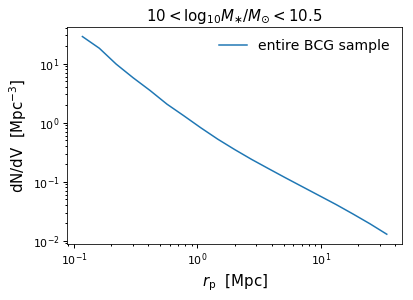

In [61]:
fig, ax = plt.subplots(1, 1)
ax.loglog()
__=ax.plot(rbin_mids, number_density(bcg_data['pair_counts'], shell_volumes), 
           label='entire BCG sample')

xlabel = ax.set_xlabel(r'$r_{\rm p}$  ${\rm [Mpc]}$', size=15)
ylabel = ax.set_ylabel(r'${\rm dN/dV}$  ${\rm [Mpc^{-3}]}$', size=15)
title = ax.set_title(r'$10 < \log_{10}M_{\ast}/M_{\odot} < 10.5$', size=15)
legend = ax.legend(fontsize=14)

fig.savefig('pair_counts.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

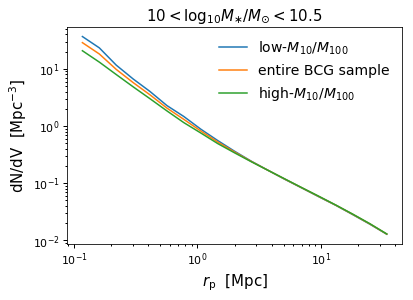

In [62]:
mask = bcg_data['logm_10'] - bcg_data['logm_100'] < np.median(bcg_data['logm_10'] - bcg_data['logm_100'])

low_frac10, high_frac10 = bcg_data[mask], bcg_data[~mask]

fig, ax = plt.subplots(1, 1)
ax.loglog()

__=ax.plot(rbin_mids, number_density(bcg_data['pair_counts'][mask], shell_volumes), 
           label=r'low-$M_{10}/M_{100}$')
__=ax.plot(rbin_mids, number_density(bcg_data['pair_counts'], shell_volumes), 
           label='entire BCG sample')
__=ax.plot(rbin_mids, number_density(bcg_data['pair_counts'][~mask], shell_volumes), 
           label=r'high-$M_{10}/M_{100}$')

xlabel = ax.set_xlabel(r'$r_{\rm p}$  ${\rm [Mpc]}$', size=15)
ylabel = ax.set_ylabel(r'${\rm dN/dV}$  ${\rm [Mpc^{-3}]}$', size=15)
title = ax.set_title(r'$10 < \log_{10}M_{\ast}/M_{\odot} < 10.5$', size=15)
legend = ax.legend(fontsize=14)
fig.savefig('pair_counts_split.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')